### **Assignment 3  - Individual project - Large Language Models**

In [1]:
# Install kerastuner
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


Installing all the datasets

In [2]:
# Install the datasets library
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


# Importing all the necessary libraries

In [3]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from kerastuner.tuners import Hyperband
import pandas as pd

<ipython-input-3-736d2f7ae36b>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [4]:
from datasets import load_dataset

# Load the dataset with a specific configuration name
dataset = load_dataset("pig4431/AmazonPolarity_train25k_test5k_valid5k")

# Convert dataset to pandas DataFrame
df = pd.DataFrame(dataset["test"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating validate split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [5]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Preprocessing the texts

In [8]:
from datasets import load_dataset
import pandas as pd
from textblob import TextBlob
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Join tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

# Apply text preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)


In [9]:
# Sentiment analysis function
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
df['sentiment'] = df['clean_text'].apply(get_sentiment)

In [10]:
# Display results
print("\nSample of Data with Sentiment:")
print(df[['clean_text', 'sentiment']].head(10))


Sample of Data with Sentiment:
                                          clean_text sentiment
0  mystic warrior excellent story three world act...  positive
1  excellent book researching woman politics easy...  positive
2  also could register sent email tech support go...   neutral
3  thought book good book anyone like adventure s...  positive
4  cd player cool cool portable take anywhere als...  positive
5  ian page way overrated secret affair plain ol ...  negative
6  received cartridge hp 74 black ink tried inser...  negative
7  totally jazzed hype internet radio bought 15 r...  positive
8               thinking wrote itthis truly shocking  negative
9  sweet lil 7band eq fancy feature huge price ta...  positive


# Applying some EDA for the dataset taken so that we get a clear view idea on the dataset working

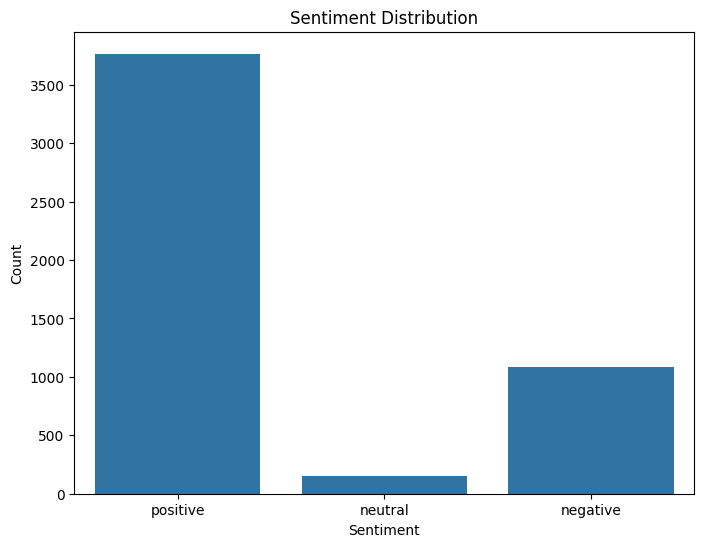

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Plot of Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

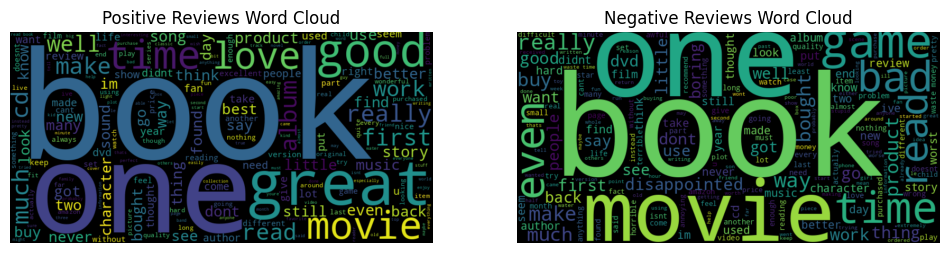

In [12]:
# 2. Word Clouds
from wordcloud import WordCloud

positive_text = ' '.join(df[df['sentiment'] == 'positive']['clean_text'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['clean_text'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')
plt.show()

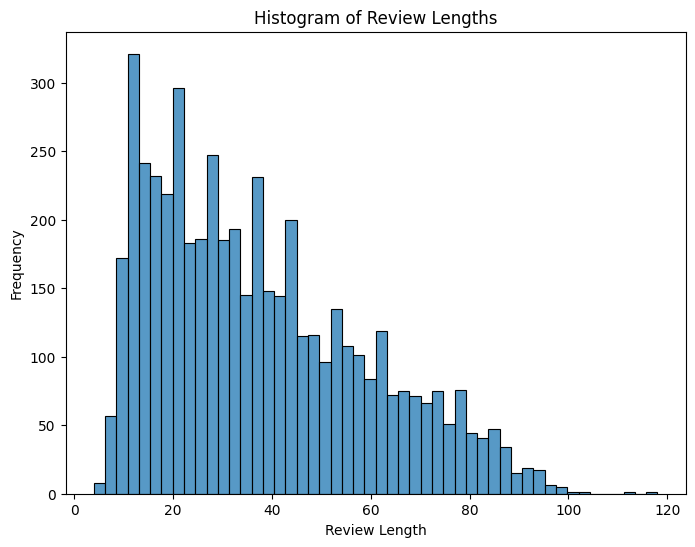

In [13]:
# 3. Histogram of Review Lengths
df['review_length'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(df['review_length'], bins=50)
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

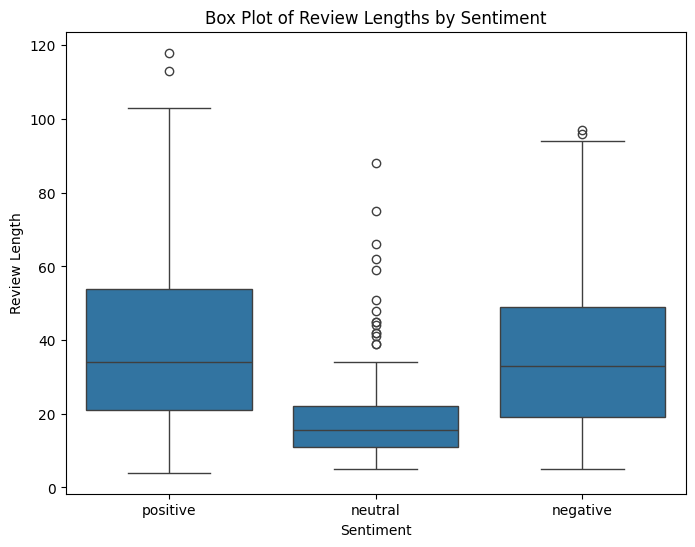

In [14]:
# 4. Box Plot of Review Lengths by Sentiment
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'sentiment', y ='review_length', data = df)
plt.title('Box Plot of Review Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

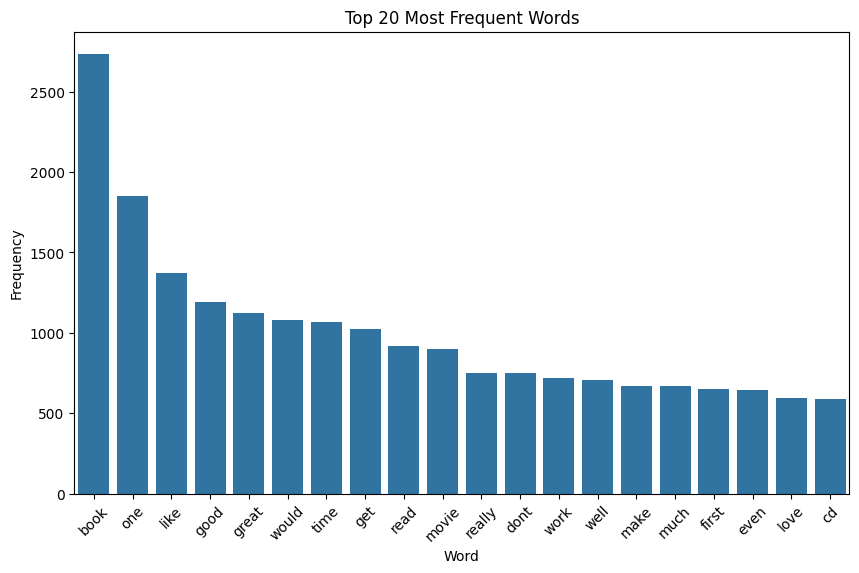

In [15]:
# 5. Word Frequency Distribution
from collections import Counter

word_counts = Counter(' '.join(df['clean_text']).split())
word_counts_df = pd.DataFrame(word_counts.items(), columns = ['Word', 'Frequency'])
word_counts_df = word_counts_df.sort_values(by = 'Frequency', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = 'Word', y = 'Frequency', data = word_counts_df.head(20))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.show()

# Tokenization of data using BERTTokenizer for the data train, validation and test

In [16]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

# Step 1: Load the Pre-trained Language Model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 labels for binary classification (positive and negative)

# Step 2: Prepare the Dataset
dataset = load_dataset("pig4431/AmazonPolarity_train25k_test5k_valid5k")
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

# Split the train dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

# Print dataset sizes
print("Train set size:", len(train_texts))
print("Validation set size:", len(val_texts))
print("Test set size:", len(test_texts))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train set size: 22500
Validation set size: 2500
Test set size: 5000


In [17]:
import tensorflow as tf
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize train, validation, and test sets
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Convert labels to tensors (if not already tensors)
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

# Print the size of the tokenized datasets
print("Tokenized Train Dataset Size:", len(train_dataset))
print("Tokenized Validation Dataset Size:", len(val_dataset))
print("Tokenized Test Dataset Size:", len(test_dataset))


Tokenized Train Dataset Size: 22500
Tokenized Validation Dataset Size: 2500
Tokenized Test Dataset Size: 5000


In [18]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Convert sentiment labels to numerical values
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Split the dataset into train and evaluation sets
train_texts, eval_texts, train_labels, eval_labels = train_test_split(df['clean_text'], df['sentiment'], test_size=0.1, random_state=42)

# Tokenize train and evaluation sets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
eval_encodings = tokenizer(list(eval_texts), truncation=True, padding=True)

# Convert encodings and labels to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: train_encodings[key] for key in ['input_ids', 'attention_mask']},
    train_labels
))

eval_dataset = tf.data.Dataset.from_tensor_slices((
    {key: eval_encodings[key] for key in ['input_ids', 'attention_mask']},
    eval_labels
))

# Print the size of the tokenized datasets
print("Tokenized Train Dataset Size:", len(train_dataset))
print("Tokenized Evaluation Dataset Size:", len(eval_dataset))


Tokenized Train Dataset Size: 4500
Tokenized Evaluation Dataset Size: 500


In [19]:
from sklearn.model_selection import train_test_split

# Check the size of the dataset
print("Size of the filtered dataset:", len(df))

# Ensure that the dataset has enough instances for splitting
if len(df) > 0:
    # Split the dataset into train and evaluation sets
    train_texts, eval_texts, train_labels, eval_labels = train_test_split(df['clean_text'], df['sentiment'], test_size=0.1, random_state=42)

    # Print the size of the train and evaluation sets
    print("Size of the train set:", len(train_texts))
    print("Size of the evaluation set:", len(eval_texts))
else:
    print("The dataset is too small to split.")


Size of the filtered dataset: 5000
Size of the train set: 4500
Size of the evaluation set: 500


# Training the model with epchos of 10 and batchsize 28 for the better accuracy

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 1.9601, Accuracy: 0.7590


Epoch 2/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 2/10, Average Loss: 0.5314, Accuracy: 0.8752


Epoch 3/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 3/10, Average Loss: 0.5334, Accuracy: 0.8756


Epoch 4/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 4/10, Average Loss: 0.5300, Accuracy: 0.8768


Epoch 5/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 5/10, Average Loss: 0.5311, Accuracy: 0.8796


Epoch 6/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 6/10, Average Loss: 0.5311, Accuracy: 0.8790


Epoch 7/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 7/10, Average Loss: 0.5330, Accuracy: 0.8786


Epoch 8/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 8/10, Average Loss: 0.5310, Accuracy: 0.8770


Epoch 9/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 9/10, Average Loss: 0.5317, Accuracy: 0.8782


Epoch 10/10:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 10/10, Average Loss: 0.5312, Accuracy: 0.8782


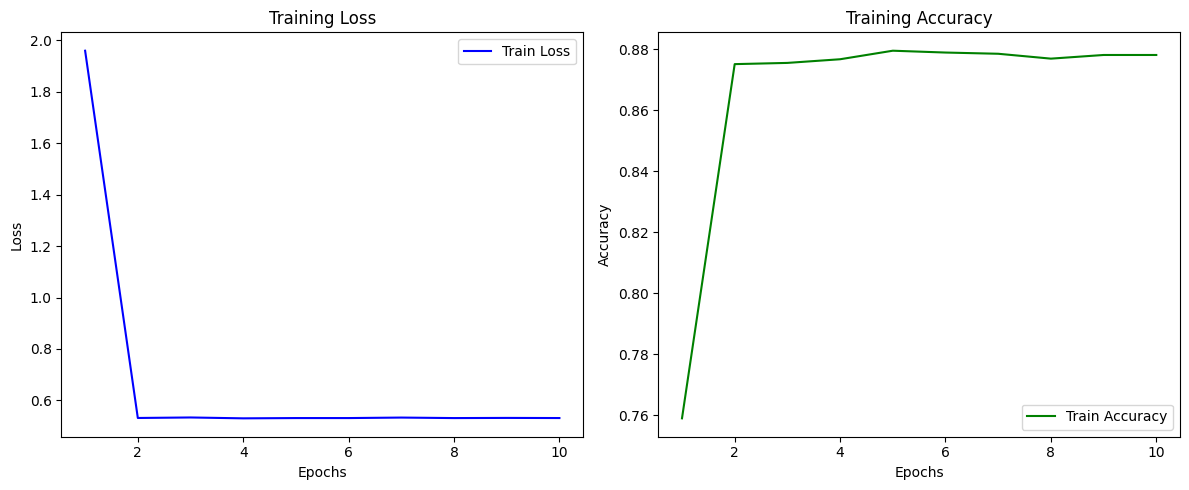

In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm.auto import tqdm  # Import tqdm for progress bar

# Preprocess the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(texts, labels):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True,
                            max_length = 128,
                            truncation = True,  # truncation is explicitly activated
                            padding = 'max_length',
                            return_attention_mask = True,
                            return_tensors =' pt',
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Assuming data in a DataFrame called df
texts = df['clean_text'].tolist()
labels = df['sentiment'].tolist()

input_ids, attention_masks, labels = preprocess_data(texts, labels)

# Create a PyTorch dataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a DataLoader
batch_size = 28
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define BERT model, optimizer, scheduler, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 5000
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_labels).to(device)
optimizer = AdamW(model.parameters(), lr = 5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = len(train_loader))
loss_fn = torch.nn.CrossEntropyLoss()

# Define max gradient norm for gradient clipping
max_grad_norm = 1.0

# Train  model
num_epochs = 10

# Lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_loader, desc = f'Epoch {epoch + 1}/{num_epochs}')

    for batch in progress_bar:
        input_ids_batch, attention_masks_batch, labels_batch = batch
        input_ids_batch, attention_masks_batch, labels_batch = input_ids_batch.to(device), attention_masks_batch.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids_batch, attention_mask = attention_masks_batch)
        logits = outputs.logits
        loss = loss_fn(logits, labels_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == labels_batch).sum().item()
        total_predictions += labels_batch.size(0)
        progress_bar.set_postfix({'loss': total_loss / len(progress_bar)})

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    # Append the values to the lists for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plotting loss and accuracy
plt.figure(figsize = (12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label = 'Train Loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label = 'Train Accuracy', color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
val_texts = df['clean_text'].tolist()
val_labels = df['sentiment'].tolist()

# Preprocess the validation data
val_input_ids, val_attention_masks, val_labels = preprocess_data(val_texts, val_labels)

# Create a PyTorch dataset for validation
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

# Create a DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # shuffle is False for validation

# Evaluate the model on the validation dataset
model.eval()
val_loss = 0
val_correct = 0
val_total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids_batch, attention_masks_batch, labels_batch = batch
        input_ids_batch, attention_masks_batch, labels_batch = input_ids_batch.to(device), attention_masks_batch.to(device), labels_batch.to(device)

        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits
        val_loss += loss_fn(logits, labels_batch).item()

        _, predicted = torch.max(logits, 1)
        val_correct += (predicted == labels_batch).sum().item()
        val_total += labels_batch.size(0)

val_accuracy = val_correct / val_total
val_avg_loss = val_loss / len(val_loader)
print(f"Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.5066, Validation Accuracy: 0.8816


In [23]:
# Prepare your test data (if not already done)
test_texts = df['clean_text'].tolist()
test_labels = df['sentiment'].tolist()

# Preprocess the test data
test_input_ids, test_attention_masks, test_labels = preprocess_data(test_texts, test_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # shuffle is False for testing

# Evaluate on the test dataset
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids_batch, attention_masks_batch, labels_batch = batch
        input_ids_batch, attention_masks_batch, labels_batch = input_ids_batch.to(device), attention_masks_batch.to(device), labels_batch.to(device)

        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits
        test_loss += loss_fn(logits, labels_batch).item()

        _, predicted = torch.max(logits, 1)
        test_correct += (predicted == labels_batch).sum().item()
        test_total += labels_batch.size(0)

test_accuracy = test_correct / test_total
test_avg_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.5066, Test Accuracy: 0.8816


# Saving the model and testing for the new infernce texts with the accuracy of 88%

In [24]:
# New inference texts and labels
new_inference_texts = [
    "The movie was fantastic, I loved every moment of it!",
    "The customer service was terrible, I had a really bad experience.",
    "I feel indifferent about this product, it neither impressed me nor disappointed me.",
    "The new software update is amazing, it has improved the performance significantly.",
    "I'm really disappointed with the performance of this device, it's not worth the price."
]

new_inference_labels = [2, 0, 1, 2, 0]  # Assign labels: Positive, Negative, Neutral, Positive, Negative

# Preprocess the new inference data
new_inference_input_ids, new_inference_attention_masks, _  = preprocess_data(new_inference_texts, new_inference_labels)
new_inference_dataset = TensorDataset(new_inference_input_ids, new_inference_attention_masks)
new_inference_loader = DataLoader(new_inference_dataset, batch_size=batch_size)

# Perform inference with the new data
model.eval()
new_inference_outputs = []
# Map labels to their corresponding sentiment
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

with torch.no_grad():
    for batch in new_inference_loader:
        input_ids_batch, attention_masks_batch = batch
        input_ids_batch, attention_masks_batch = input_ids_batch.to(device), attention_masks_batch.to(device)

        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        new_inference_outputs.extend(predicted.cpu().numpy())

# Print inference results for the new data
print("New Inference Results:")
for text, true_label, predicted_label_id in zip(new_inference_texts, new_inference_labels, new_inference_outputs):
    predicted_label = sentiment_map[predicted_label_id]
    print(f"Sentence: {text}")
    print(f"True Label: {sentiment_map[true_label]}")
    print(f"Predicted Label: {predicted_label}")
    print()


New Inference Results:
Sentence: The movie was fantastic, I loved every moment of it!
True Label: Positive
Predicted Label: Positive

Sentence: The customer service was terrible, I had a really bad experience.
True Label: Negative
Predicted Label: Negative

Sentence: I feel indifferent about this product, it neither impressed me nor disappointed me.
True Label: Neutral
Predicted Label: Positive

Sentence: The new software update is amazing, it has improved the performance significantly.
True Label: Positive
Predicted Label: Positive

Sentence: I'm really disappointed with the performance of this device, it's not worth the price.
True Label: Negative
Predicted Label: Negative



# printing the Confusion matrix

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Convert lists to numpy arrays
true_labels = np.array(new_inference_labels)
predicted_labels = np.array(new_inference_outputs)

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute precision, recall, and F1-score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8
Precision: [1.         0.         0.66666667]
Recall: [1. 0. 1.]
F1-score: [1.  0.  0.8]
Confusion Matrix:
[[2 0 0]
 [0 0 1]
 [0 0 2]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification report

In [27]:
from sklearn.metrics import classification_report

# Evaluate the model on the validation dataset
model.eval()
val_loss = 0
val_correct = 0
val_total = 0
predicted_labels_list = []
true_labels_list = []

with torch.no_grad():
    for batch in val_loader:
        input_ids_batch, attention_masks_batch, labels_batch = batch
        input_ids_batch, attention_masks_batch, labels_batch = input_ids_batch.to(device), attention_masks_batch.to(device), labels_batch.to(device)

        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits
        val_loss += loss_fn(logits, labels_batch).item()

        _, predicted = torch.max(logits, 1)
        val_correct += (predicted == labels_batch).sum().item()
        val_total += labels_batch.size(0)

        predicted_labels_list.extend(predicted.cpu().numpy())
        true_labels_list.extend(labels_batch.cpu().numpy())

val_accuracy = val_correct / val_total
val_avg_loss = val_loss / len(val_loader)
print(f"Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Generate classification report
classification_rep = classification_report(true_labels_list, predicted_labels_list)
print("Classification Report:")
print(classification_rep)


Validation Loss: 0.5066, Validation Accuracy: 0.8816
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1084
           1       0.00      0.00      0.00       150
           2       0.91      0.95      0.93      3766

    accuracy                           0.88      5000
   macro avg       0.56      0.57      0.57      5000
weighted avg       0.85      0.88      0.87      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
